## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [145]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

plt.style.use('fivethirtyeight')

%matplotlib inline

In [146]:
# setup display range
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [147]:
# load data
df = pd.read_csv('chronic_kidney_disease_full.csv')

In [148]:
# review the top 5 lines
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer:

Based on the paper and general medical knowledge, I will be interested in checking out the following features:
1. bp: blood pressure
2. sg: sugar
3. al: albumin - this is usually associated with kidney failure
4. su: blood sugar
5. rbc: red blood cell
6. pcc: pus cell clamps
7. bu: blood urine
8. sc: serum creatinine - another key indicator for kidney failure
9. htn: hypertension
10. dm:	diabetes mellitus
11. cad: coronary artery disease
12. pe: pedal edema
13. ane: anemia

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
age      391 non-null float64
bp       388 non-null float64
sg       353 non-null float64
al       354 non-null float64
su       351 non-null float64
rbc      248 non-null object
pc       335 non-null object
pcc      396 non-null object
ba       396 non-null object
bgr      356 non-null float64
bu       381 non-null float64
sc       383 non-null float64
sod      313 non-null float64
pot      312 non-null float64
hemo     348 non-null float64
pcv      329 non-null float64
wbcc     294 non-null float64
rbcc     269 non-null float64
htn      398 non-null object
dm       398 non-null object
cad      398 non-null object
appet    399 non-null object
pe       399 non-null object
ane      399 non-null object
class    400 non-null object
dtypes: float64(14), object(11)
memory usage: 78.2+ KB


---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

Based on the value below, there are many features missing more than 20% of the data. Since 'al' is a very important feature to identify the CKD, i would use it's missing % (i.e., 11.5%) as the feature select threshold.

In [150]:
# missing value % for each feature
miss_val = df.isna().mean()
miss_val

age      0.0225
bp       0.0300
sg       0.1175
al       0.1150
su       0.1225
rbc      0.3800
pc       0.1625
pcc      0.0100
ba       0.0100
bgr      0.1100
bu       0.0475
sc       0.0425
sod      0.2175
pot      0.2200
hemo     0.1300
pcv      0.1775
wbcc     0.2650
rbcc     0.3275
htn      0.0050
dm       0.0050
cad      0.0050
appet    0.0025
pe       0.0025
ane      0.0025
class    0.0000
dtype: float64

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

Answer:

For complease case analysis, there will only be 158 rows remaining in the data. Here are the downsides:
1. We loses majority of the data, which may significantly reduces the statistical power.
2. The model built upon these data may be more biased.

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer:

1. Most of these data seems from lab work, usually through blood and urine test. There are several featuers such as blood sugar/glucose varies based on when the blood test was taken (usually should be fast). The number could be questioned if the test was not done with empty stomach.

2. Some of the data seem from medical history (htn, dm, cad).

3. If these data were put together manually, there could be human error for missing/incorrect data.

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer:

I will build a model classifying **all patients have CKD**.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:

We optimize **sensitivity** which minimizing the **false negative**.

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer:

Telling healthy patients that they have CKD will cause unnecessary panic, financial, and menal damage.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer:

I will build a model classifying **no patient has CDK**.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:

We optimize **specificity** that minimizes the **false positive** or false alarm.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer:

Telling patient with CDK that they are healthy may cause miss or delay needed treatment.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

#### 12.1 EDA

> Based on EDA, following variables are chosen
1. bp: blood pressure
2. al: albumin
3. bu: blood urea
4. pcc: pus cell clump
4. sc: serum creatinine
5. htn: hypertension
6. dm: diabetes mellitus
7. pe: pedal adema
8. ane: anemia

['al', 'bu', 'sc', 'htn', 'dm', 'pe', 'ane']

In [151]:
df['class'] = df['class'].apply(lambda x: 1 if x == 'ckd' else 0)

In [152]:
df.head(3)

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,1
1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,1
2,62.0,80.0,1.01,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,1


In [153]:
# Select features using missing value % threshold
features = miss_val[miss_val < 0.1180].keys()
features

Index(['age', 'bp', 'sg', 'al', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class'], dtype='object')

<Figure size 1296x1080 with 0 Axes>

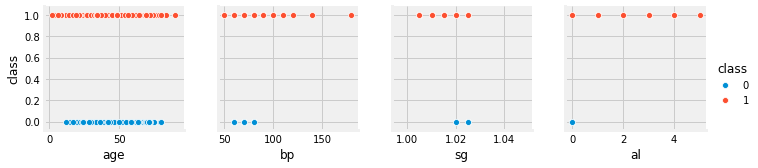

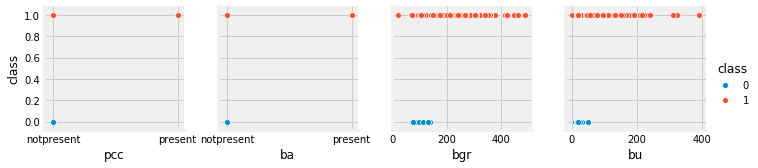

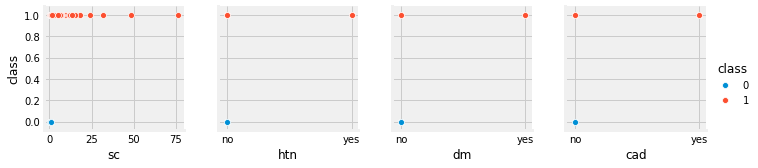

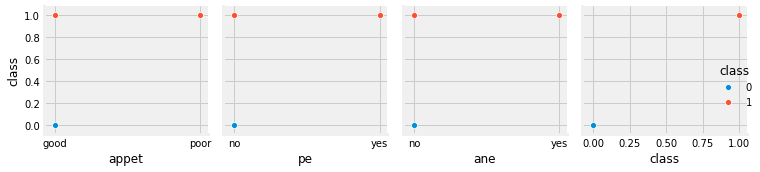

In [154]:
plt.figure(figsize = (18,15))
sns.pairplot(df, x_vars=list(features[0:4]), y_vars=['class'], hue='class')
sns.pairplot(df, x_vars=list(features[4:8]), y_vars=['class'], hue='class')
sns.pairplot(df, x_vars=list(features[8:12]), y_vars=['class'], hue='class')
sns.pairplot(df, x_vars=list(features[12:16]), y_vars=['class'], hue='class')
plt.tight_layout();

In [155]:
df = df[features].dropna()

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


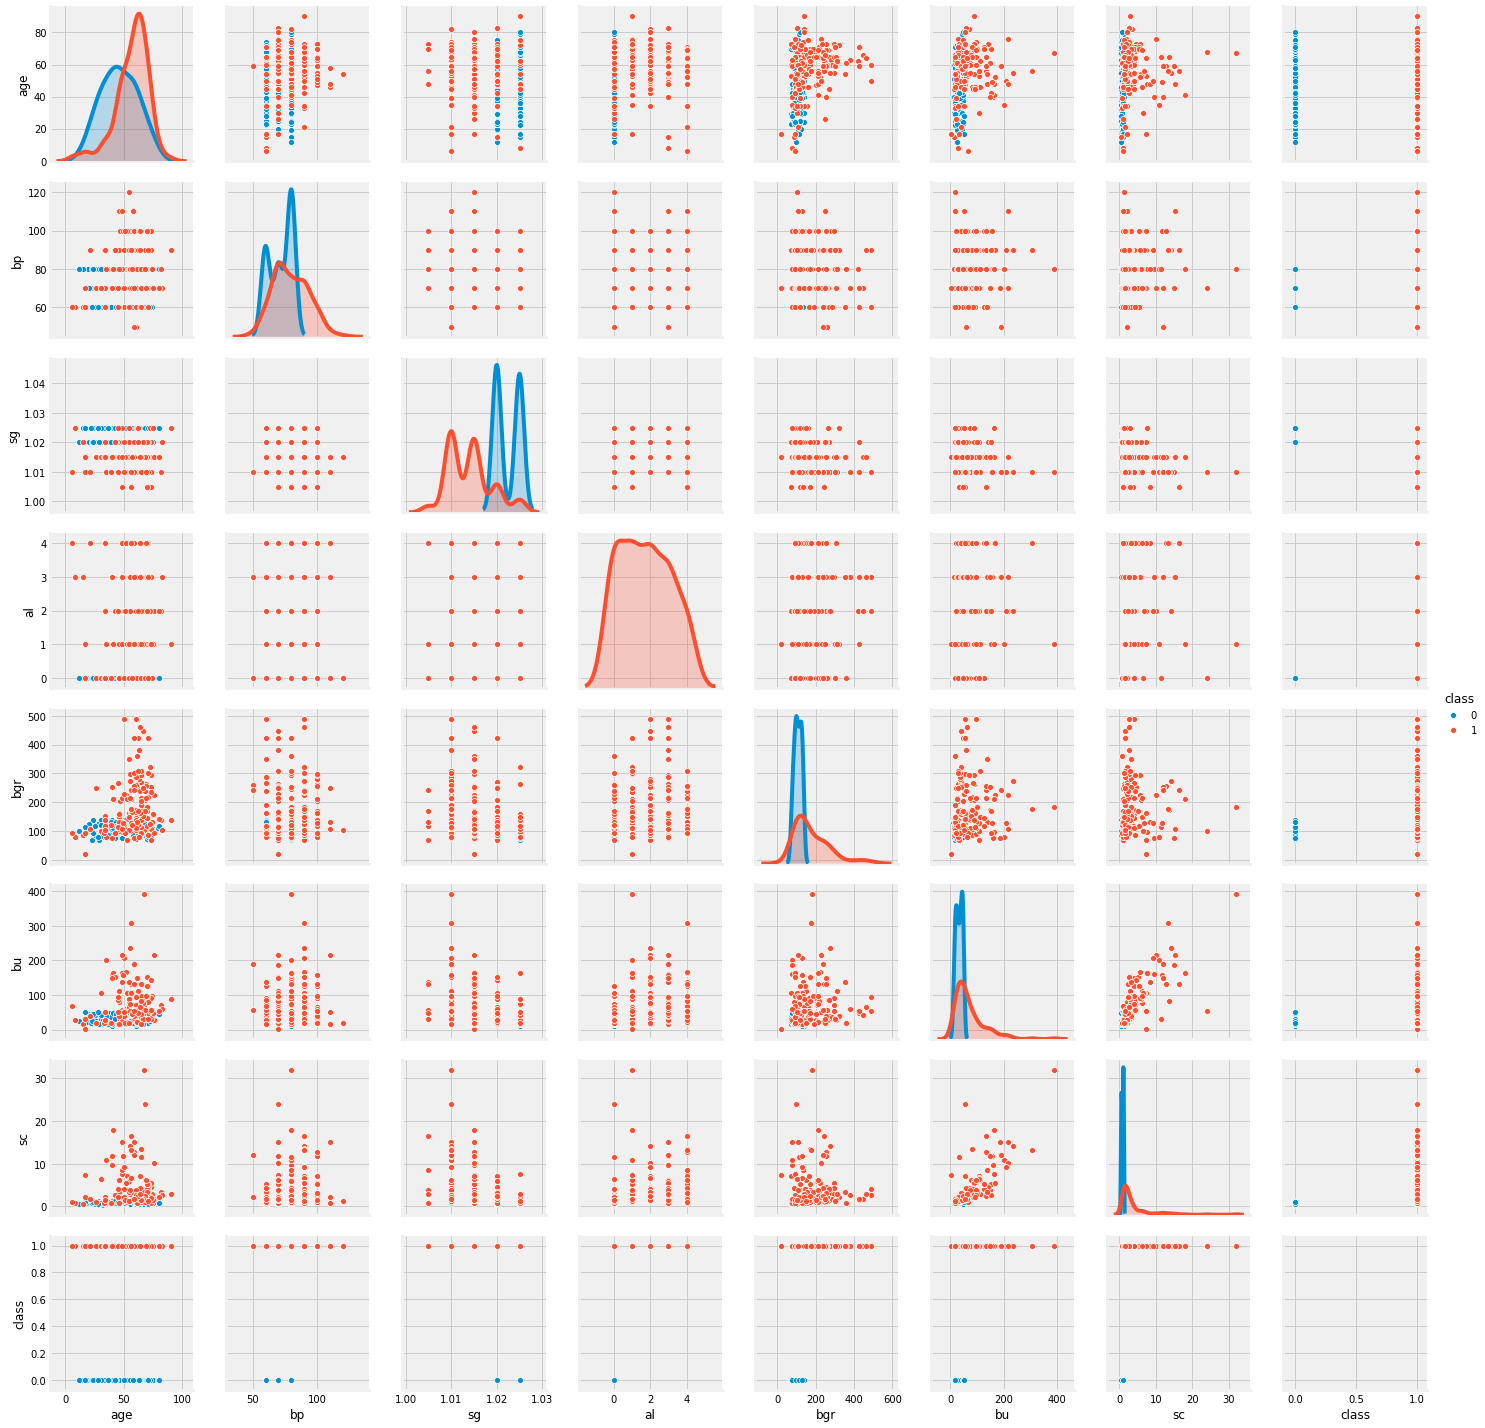

In [156]:
sns.pairplot(df, hue='class')

#### 12.2 Prepare Data - Data Cleaning

In [157]:
# Reload data
df = pd.read_csv('chronic_kidney_disease_full.csv')

In [158]:
# Select Features:
features = ['bp',
            #'sg',
            'al', 
            #'bgr',
            'bu',
            #'pcc',
            #'ba',
            'sc', 
            'htn', 
            'dm',
            #'cad',
            'pe', 
            'ane', 
            'class']
df = df[features]
df.shape

(400, 9)

In [159]:
# Remove missing values
df = df.dropna()
df.shape

(324, 9)

#### 12.3 Feature Engineering

In [160]:
df.head(3)

,bp,al,bu,sc,htn,dm,pe,ane,class
0,80.0,1.0,36.0,1.2,yes,yes,no,no,ckd
1,50.0,4.0,18.0,0.8,no,no,no,no,ckd
2,80.0,2.0,53.0,1.8,no,yes,no,yes,ckd


In [161]:
# Create dummy variables
for feature in [#'ba',
                #'pcc',
                'htn', 
                'dm', 
                #'cad',
                'pe', 
                'ane']:
    df[feature] = df[feature].apply(lambda x: 1 if x == 'yes' else 0)

df['class'] = df['class'].apply(lambda x: 1 if x == 'ckd' else 0)
df.head(3)

,bp,al,bu,sc,htn,dm,pe,ane,class
0,80.0,1.0,36.0,1.2,1,1,0,0,1
1,50.0,4.0,18.0,0.8,0,0,0,0,1
2,80.0,2.0,53.0,1.8,0,1,0,1,1


#### 12.4 Create X, y

In [162]:
X = df.iloc[:, :-1]
y = df['class']

In [163]:
X.head(3)

,bp,al,bu,sc,htn,dm,pe,ane
0,80.0,1.0,36.0,1.2,1,1,0,0
1,50.0,4.0,18.0,0.8,0,0,0,0
2,80.0,2.0,53.0,1.8,0,1,0,1


#### 12.5 Regular Approach

In [164]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [165]:
# import pipe library
from sklearn.pipeline import Pipeline

In [166]:
# use pipe
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(penalty='l1', C=1, solver='liblinear'))
])

# Fit
pipe.fit(X_train, y_train)

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [167]:
# Training accuracy score
pipe.score(X_train, y_train)

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9588477366255144

In [168]:
# Cross validation to make sure the train/test split is good
cross_val_score(pipe, X_train, y_train, cv=10).mean()

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWa

0.9376376811594203

In [169]:
# Testing data accuracy
pipe.score(X_test, y_test)

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9753086419753086

In [170]:
# predict y
y_pred = pipe.predict(X_test)

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [171]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred_no ckd', 'pred_ckd'], index = ['actual_no ckd', 'actual_ckd'])
cm_df

,pred_no ckd,pred_ckd
actual_no ckd,30,0
actual_ckd,2,49


#### 12.6 Grid Search

In [172]:
# import grid search library
from sklearn.model_selection import GridSearchCV

In [173]:
# parameters for iteration
lr_params = {
    'penalty': ['l1','l2'],
    'C': np.logspace(-4, 3, 1000),
#     'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
}

# GridSearchCV setup
lr_gridsearch = GridSearchCV(
    LogisticRegression(),
    lr_params,
    cv=5,
    verbose=1,
    n_jobs=4,
    return_train_score=False
)

# GridSearch Fit
lr_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 150 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 10000 out of 10000 | elapsed:   16.9s finished
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-04, 1.01627e-04, ..., 9.83995e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=1)

In [174]:
# Best accuracy
lr_gridsearch.best_score_

0.9629629629629629

In [175]:
# Best parameter
lr_gridsearch.best_params_

{'C': 48.159579101923505, 'penalty': 'l2'}

In [176]:
# Best estimator
best_lr = lr_gridsearch.best_estimator_
best_lr.score(X_test, y_test)

0.9753086419753086

In [177]:
gs_df = pd.DataFrame(lr_gridsearch.cv_results_)
gs_df = gs_df[gs_df['param_penalty'] == 'l2']

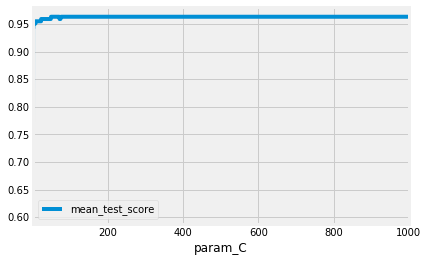

In [178]:
gs_df.plot(x='param_C', y='mean_test_score')

In [179]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in best_lr.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

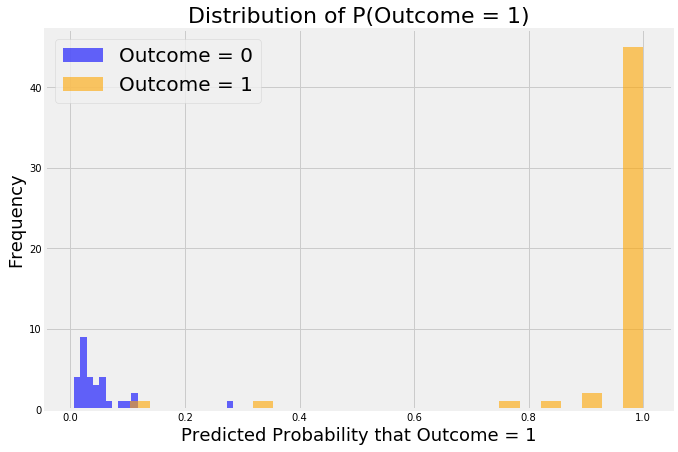

In [180]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [181]:
# DF for coefficient
df_coef = pd.DataFrame({'Feature': features[:-1], 
                        'Feature Full': ['Blood Pressure',
                                         'Albumin',
                                         'Blood Urine',
                                         'Serum Creatinine',
                                         'Hypertension',
                                         'Diabete Mellitus',
                                         'Pedal Edema',
                                         'Anemia'
                                        ],
                        'Coefficient': best_lr.coef_.ravel(),
                        'Change of Odds': np.exp(df_coef['Coefficient']),
                        'Type': ['quan']*4+['qual']*4,
                       })
df_coef

,Feature,Feature Full,Coefficient,Change of Odds,Type
0,bp,Blood Pressure,0.046012,1.047087,quan
1,al,Albumin,5.009504,149.830476,quan
2,bu,Blood Urine,-0.052686,0.948678,quan
3,sc,Serum Creatinine,2.225830,9.261166,quan
4,htn,Hypertension,4.554948,95.101834,qual
5,dm,Diabete Mellitus,4.204233,66.969206,qual
6,pe,Pedal Edema,4.548775,94.516572,qual
7,ane,Anemia,4.214079,67.631848,qual


For every nominal category increase in Albumin, the patient's odds of being classified as CKD increase by about 150 times (exp(5.009504))

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

Having pedal edema increase the patient's odds being classiefied as CKD by about 94.5 times (exp(4.55)). 

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer:
1. Logistic model is a parametric model. In addition to classifying data, the model also return important parameters (e.g., beta) to explain the relationship between the features and the dependent variable. 
2. Logistic regression is flexible where you can adjust the classificaiton threshold based on the goal of the model.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

It would make sense to generate a confusion matrix on testing dataset, because the purpose of the model is trained from the training data and is to classified the data outside the training data. 

In [182]:
# Confusion Matrix (see 12.5)
cm_df

,pred_no ckd,pred_ckd
actual_no ckd,30,0
actual_ckd,2,49


### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer:

We should optimize the sensitiveity to minimize the false negative so that no patient with CKC would be told that he/she is healthy. The damage caused by false alarm (false positive) could mostly be mitigated. However, the consequence of missing or delay the needed treatment is irreversible.

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer:
Unbalance classes usually cause problem through given unbalanced amount of data for each class. For instance, if 90% of the data is class A and 10% of the data is class B. We may not get enough information to accurately identify class B due to lack of information to learn.

In [183]:
df['class'].value_counts()

1    190
0    134
Name: class, dtype: int64

Based on the count above, out database is unbalanced. CKD is the majority class.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer:

In order to classify the patient into healthy or unhealthy, we need to learn from enough data from both classes. However, unbalanced class may provide much informatino for one class but not enough for the other, which may leads to criterias we used to classify the patient bias towards one class.  

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [184]:
# create ckd only dataframe
df_ckd = df[df['class'] == 1]
df_no_ckd = df[df['class'] == 0]

In [185]:
# sampling
df_ckd = df_ckd.sample(n = 200000, replace=True, random_state=42)
df_ckd.shape

(200000, 9)

In [186]:
# concatenate the sample with original data
df_unb = pd.concat([df_ckd, df], axis=0)

In [187]:
# check the shape
df_unb.shape

(200324, 9)

In [188]:
# check the CKD and non_CKD patients
df_unb['class'].value_counts()

1    200190
0       134
Name: class, dtype: int64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [189]:
# review the new data
df_unb.head()

,bp,al,bu,sc,htn,dm,pe,ane,class
128,90.0,4.0,166.0,5.6,1,1,0,1,1
237,70.0,2.0,53.0,2.2,1,1,1,0,1
116,70.0,4.0,16.0,0.5,0,0,1,0,1
16,70.0,2.0,46.0,2.2,0,0,0,0,1
133,100.0,4.0,125.0,5.3,1,0,0,0,1


In [190]:
# prepare X and y
X = df_unb.iloc[:, :-1]
y = df_unb['class']

In [191]:
# train/test split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, random_state=42)

In [192]:
# pipe
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr_s', LogisticRegression(penalty='l1', C=1, solver='liblinear'))
])

# Fit
pipe.fit(X_train_s, y_train_s)

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr_s', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [193]:
# cross_val_score(pipe, X_train_s, y_train_s, cv=10).mean()

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWa

0.9993876601652554

In [194]:
pipe.score(X_train_s, y_train_s)

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9994076263120412

In [195]:
pipe.score(X_test_s, y_test_s)

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.999440905732713

In [196]:
y_pred_s = pipe.predict(X_test_s)

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [197]:
cm_s = confusion_matrix(y_test_s, y_pred_s)
cm_s_df = pd.DataFrame(cm_s, columns = ['pred_no ckd', 'pred_ckd'], index = ['actual_no ckd', 'actual_ckd'])
cm_s_df

,pred_no ckd,pred_ckd
actual_no ckd,3,28
actual_ckd,0,50050


High False Alarm!

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

As shown in teh confusion matrix above, there are more cases for false alarm (false positive). The reason is that in this unbalanced data, our method didn't study enough from the patient with no CKD and therefore not able to accurately classify healthy individuals. In statistical term, the this model has sensitivity of 1 but specificity of 0.1. To improve the model, we need to use a more balanced dataset. We can:
1. increase the datasize by collecting more data
2. sample and assemble a more balanced dataset.